# Predicting mets

In [1]:
import sys
sys.path.append('../src/')

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from unet import eval_preds

from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

from pathlib import Path
from torch import FloatTensor as FT

torch.cuda.set_device(0)

#  load images

In [3]:
# Read images
data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_2mets/")
trn_img = sorted(list(Path(data_path/"training/skull_stripped_1x1x3").iterdir()))
trn_mask = sorted(list(Path(data_path/"training/mets_masks_1x1x3").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped_1x1x3").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/mets_masks_1x1x3").iterdir()))
test_img = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/mets_masks_1x1x3").iterdir()))


print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test_mask)} Images")

Size of Train Dataset Images: 113 Images
Size of Validation Dataset Images: 24 Images
Size of Train Dataset Masks: 113 Images
Size of Validation Dataset Masks: 24 Images
Size of Test 1 Dataset Images: 25 Images
Size of Test 1 Dataset Masks: 25 Images


In [4]:
class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

train_ds = MR_3D_Dataset(trn_img, trn_mask)
valid_ds = MR_3D_Dataset(valid_img, valid_mask)   
test_ds = MR_3D_Dataset(test_img, test_mask)

bs=1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=1)
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size=bs), device=data.device)
valid_dl = DeviceDataLoader(DataLoader(valid_ds, batch_size=1), device=data.device)

# load baseline 9 model (3D Residual UNet)

In [5]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

loss_func = 'dice'
model_dir = '/home/nanot/MEDomicsLab-develop-brainmets/model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
#learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.loss_func = dice_loss
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200124_first_tx_2mets_b9');

In [7]:
# get test1 predictions
learn.to_fp32();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1)
    #test_preds.sigmoid_();
    return test_preds, test_targs

i, test_preds, test_targs = get_img_pred_masks(learn,test_dl)#get_preds_targs(test_dl)

#print(learn.validate(valid_dl))

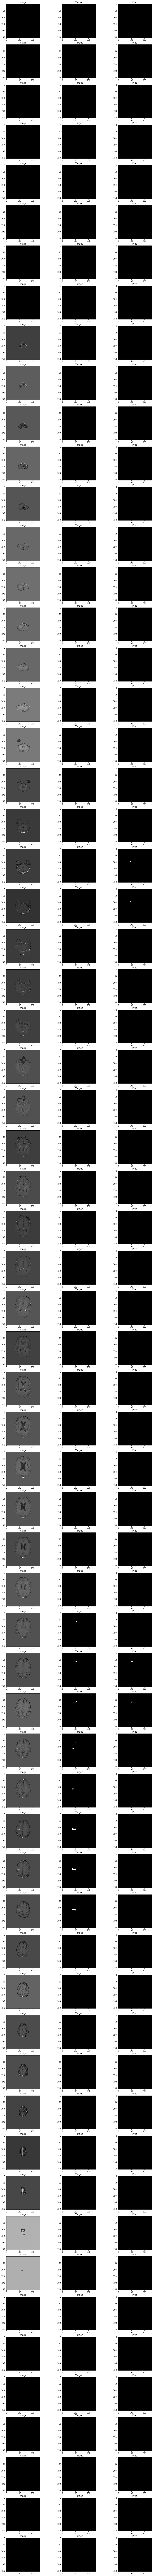

In [14]:
IMG_SET = 2
brainimgs = test_ds.__getitem__(IMG_SET)
#fig, ax = plt.subplots(55,2,figsize=(20,20))
#fig.set_size_inches(15,150)
plt.figure(figsize=(15, 500))
c = 1
for i in range(0,64):
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*brainimgs[0][0][i,:,:], cmap="gray")
    plt.title('Image')
    c = c + 1
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*test_targs[IMG_SET][i,:,:], cmap="gray")
    plt.title('Target')
    c = c + 1
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*test_preds[IMG_SET][i,:,:], cmap="gray")
    plt.title('Pred')
    c = c + 1
    #ImageSegment(128 + 128*brainimgs[0][0][40+i][None,...]).show(ax=ax[i,0], alpha=1, cmap='gray', title='Image')#('Image %i' %i))
    #ImageSegment(test_targs[IMG_SET][40+i][None,...]).show(ax=ax[i,0], alpha=1, cmap='gray', title='Target')
    #ImageSegment(baseline11_preds[IMG_SET][40+i][None,...]).show(ax=ax[i,1], alpha=1, cmap='gray', title='Baseline 11')

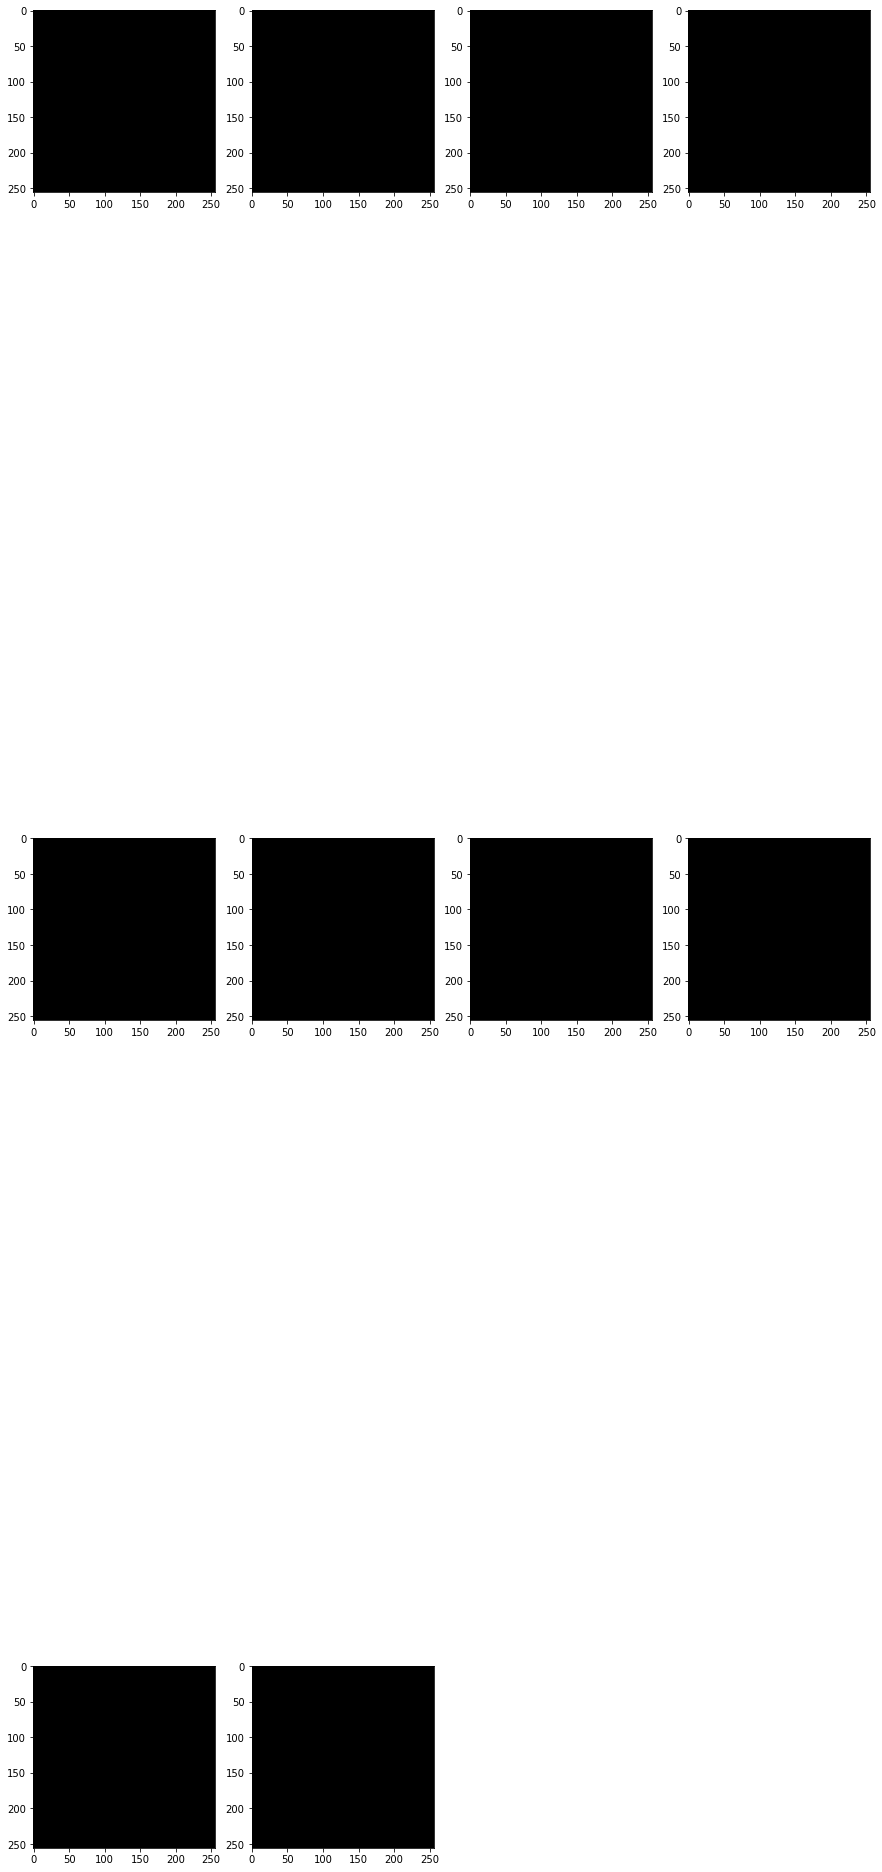

In [62]:
brainimgs = test_ds.__getitem__(IMG_SET)
#fig, ax = plt.subplots(55,1,figsize=(20,20))
#fig.set_size_inches(15,150)
plt.figure(figsize=(15, 500))
for i in range(0,):
    plt.subplot(round(128/4) + 1, 4, i+1)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray")
    #ImageSegment(brainimgs[0][0][i,:,:]).show(ax=ax[i])#('Image %i' %i))


In [61]:
len(brainimgs[0][0][:,1,1])

128

# Generate table and figures

In [8]:
def summary_table(target_masks, pred_masks, file_names):
    pred_dice_scores = [dice_score(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    pred_percent_vol_diff = [vol_perc_diff(target_masks[i], pred_masks[i], True)*100 for i in range(len(target_masks))]
    d = {'test_name': file_names,
         'pred_dice_scores': pred_dice_scores, 
         'pred_percent_vol_diff': pred_percent_vol_diff}
    df = pd.DataFrame(data=d)
    return df

def vol_perc_diff(mask, pred, absolute=False):
    #mask_vol = (((mask.numpy()).sum()).sum()).sum()
    #pred_vol = (((pred.numpy()).sum()).sum()).sum()
    mask_vol = mask.sum().sum().sum()
    pred_vol = pred.sum().sum().sum()
    if not absolute:
        return (pred_vol-mask_vol)/mask_vol
    return abs(pred_vol-mask_vol)/mask_vol

def dice_score(target, preds, thresh=0.5):
    iT = target#.numpy()
    iP = preds#.numpy()
    intersection = (((iT * iP).sum()).sum()).sum()
    return ((2.0 * intersection) / (((iT.sum()).sum()).sum() + ((iP.sum()).sum()).sum() + 1e-6))

In [9]:
pred_masks = test_preds
target_masks = test_targs

names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_2mets/")
test1_img_files = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(target_masks, pred_masks, names)
df_summary = df.describe()

baseline11_mean_d = df_summary.iloc[1]['pred_dice_scores'] # mean
baseline11_std_d = df_summary.iloc[2]['pred_dice_scores'] # std
baseline11_mean_p = df_summary.iloc[1]['pred_percent_vol_diff'] # mean
baseline11_std_p = df_summary.iloc[2]['pred_percent_vol_diff'] # std

df

,test_name,pred_dice_scores,pred_percent_vol_diff
0,BrainMets-UCSF-00012,0.917479,10.317731
1,BrainMets-UCSF-00161,0.815217,4.706968
2,BrainMets-UCSF-00195,0.139596,88.346686
3,BrainMets-UCSF-00219,0.950597,0.639550
4,BrainMets-UCSF-00224,0.890280,5.635607
5,BrainMets-UCSF-00405,0.836481,16.757741
6,BrainMets-UCSF-00428,0.916379,5.042017
7,BrainMets-UCSF-00466,0.871539,6.867329
8,BrainMets-UCSF-00745,0.816695,25.663717
9,BrainMets-UCSF-00811,0.826966,17.622951


In [10]:
df.describe()

,pred_dice_scores,pred_percent_vol_diff
count,25.000000,25.000000
mean,0.752732,35.188679
std,0.277655,75.381194
min,0.000000,0.085470
25%,0.743050,5.042017
50%,0.841060,11.543210
75%,0.910338,34.778729
max,0.950597,379.310345


In [12]:
df[df['pred_dice_scores'] >0.15].describe()

,pred_dice_scores,pred_percent_vol_diff
count,22.000000,22.000000
mean,0.849032,15.227762
std,0.080785,14.820113
min,0.645410,0.085470
25%,0.815587,4.968369
50%,0.880909,8.912407
75%,0.913440,23.653525
max,0.950597,50.245285
